In [1]:
# PTB-XL Neural Network Classifier (Binary)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import ast

# Load and preprocess data
df = pd.read_csv("/media/nicholas/Storage/Datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv")  
df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
df['diagnostic_class'] = df['scp_codes'].apply(lambda x: list(x.keys()))
df['is_NORM'] = df['diagnostic_class'].apply(lambda labels: 1 if 'NORM' in labels else 0)

df_model = df[['age', 'sex', 'height', 'weight', 'heart_axis', 'is_NORM']].dropna()
df_model['sex'] = df_model['sex'].map({'male': 1, 'female': 0})
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_class,is_NORM
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,"[NORM, LVOLT, SR]",1
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,"[NORM, SBRAD]",1
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,"[NORM, SR]",1
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,"[NORM, SR]",1
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,"[NORM, SR]",1


In [2]:
# Balance the dataset
df_norm = df_model[df_model['is_NORM'] == 1]
df_abnorm = df_model[df_model['is_NORM'] == 0].sample(n=len(df_norm), random_state=42)
df_balanced = pd.concat([df_norm, df_abnorm])

X = pd.get_dummies(df_balanced.drop(columns='is_NORM'), drop_first=True)
y = df_balanced['is_NORM']

X = X.dropna(axis=1)
X = X.loc[:, X.std() != 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [3]:
# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

In [5]:
# Define Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)
        return x

In [6]:
# Initialize
model = SimpleNN(X_train_tensor.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 10/500 - Loss: 0.6579, Accuracy: 53.24%
Epoch 20/500 - Loss: 0.6296, Accuracy: 53.24%
Epoch 30/500 - Loss: 0.5960, Accuracy: 66.19%
Epoch 40/500 - Loss: 0.5573, Accuracy: 84.89%
Epoch 50/500 - Loss: 0.5142, Accuracy: 85.61%
Epoch 60/500 - Loss: 0.4720, Accuracy: 84.89%
Epoch 70/500 - Loss: 0.4341, Accuracy: 84.89%
Epoch 80/500 - Loss: 0.4043, Accuracy: 84.89%
Epoch 90/500 - Loss: 0.3833, Accuracy: 84.89%
Epoch 100/500 - Loss: 0.3698, Accuracy: 84.89%
Epoch 110/500 - Loss: 0.3608, Accuracy: 84.89%
Epoch 120/500 - Loss: 0.3541, Accuracy: 85.61%
Epoch 130/500 - Loss: 0.3487, Accuracy: 85.61%
Epoch 140/500 - Loss: 0.3440, Accuracy: 85.61%
Epoch 150/500 - Loss: 0.3398, Accuracy: 86.33%
Epoch 160/500 - Loss: 0.3359, Accuracy: 86.33%
Epoch 170/500 - Loss: 0.3321, Accuracy: 86.33%
Epoch 180/500 - Loss: 0.3284, Accuracy: 86.33%
Epoch 190/500 - Loss: 0.3246, Accuracy: 87.05%
Epoch 200/500 - Loss: 0.3207, Accuracy: 87.05%
Epoch 210/500 - Loss: 0.3166, Accuracy: 87.05%
Epoch 220/500 - Loss: 

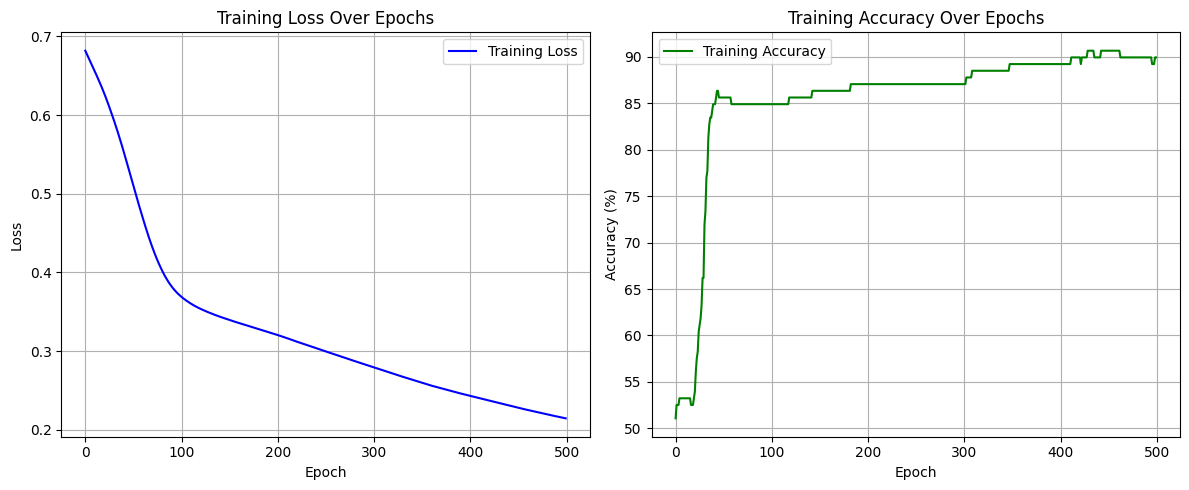

In [7]:
# Training
# epochs = 500
#for epoch in range(epochs):
   # model.train()
   # optimizer.zero_grad()
   # outputs = model(X_train_tensor)
   # loss = criterion(outputs, y_train_tensor)
   # loss.backward()
   # optimizer.step()

   # if (epoch+1) % 10 == 0:
    #    with torch.no_grad():
     #       preds = (torch.sigmoid(outputs) > 0.5).float()
      #      acc = (preds == y_train_tensor).float().mean()
       #     print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}, Accuracy: {acc.item()*100:.2f}%")

# Training

import matplotlib.pyplot as plt

# Initialize trackers
losses = []
accuracies = []

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        preds = (torch.sigmoid(outputs) > 0.5).float()
        acc = (preds == y_train_tensor).float().mean()

    losses.append(loss.item())
    accuracies.append(acc.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}, Accuracy: {acc.item() * 100:.2f}%")

# Visualization
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot([a * 100 for a in accuracies], label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
# Evaluation
model.eval()
with torch.no_grad():
    y_logits = model(X_test_tensor)
    y_probs = torch.sigmoid(y_logits).cpu().numpy().flatten()
    y_pred = (y_probs > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.88      0.82      0.85        17

    accuracy                           0.86        35
   macro avg       0.86      0.86      0.86        35
weighted avg       0.86      0.86      0.86        35

Confusion Matrix:
[[16  2]
 [ 3 14]]
ROC-AUC Score: 0.8986928104575164


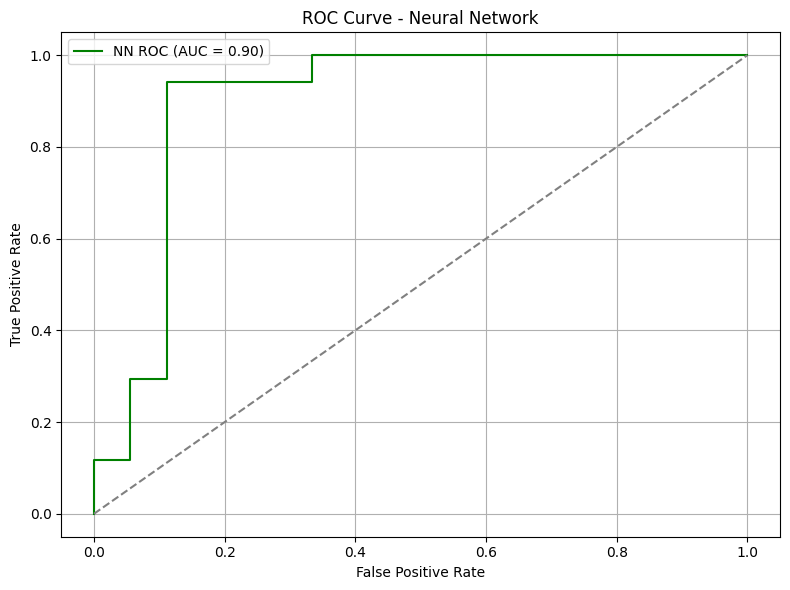

In [9]:
# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label=f'NN ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
print(f"Total records: {len(df)}")

Total records: 21799
